In [63]:
# project configurations

import sqlalchemy as sa
import numpy as np
import pandas as pd
import pylab as pl
from pandas import ExcelWriter
from pandas import ExcelFile
import datetime
import os
import zipfile
import uuid
import matplotlib
import seaborn as sns
from os.path import basename
from datetime import datetime, date, time, timedelta


client_pg = sa.create_engine('postgresql://localhost:5432/postgres')

In [15]:
# all transactions

all_trx = """
  select * from transactions order by created_date asc;
"""
df_all_trx = pd.read_sql(all_trx, client_pg)

df_all_trx.head()

,index,id,currency,amount,state,created_date,merchant_category,merchant_country,entry_method,user_id,type,source
0,524084,2602c6be-24ce-4d40-b2c9-935cfb5b8187,EUR,2000,COMPLETED,2015-03-03 11:55:44.233,None,None,misc,23dd04f8-28c8-490c-9a69-2cdffa1e0111,TOPUP,OPHION
1,524083,ebf2408d-edab-4bb8-9d36-588d310bf031,EUR,500,COMPLETED,2015-03-05 11:33:43.964,None,None,misc,23dd04f8-28c8-490c-9a69-2cdffa1e0111,P2P,INTERNAL
2,524087,0a0cbf97-8022-443b-b3cc-0e4e6a43fdb9,GBP,100,COMPLETED,2015-04-28 20:17:15.363,None,None,misc,73220926-b8eb-405a-90b8-1d770dfb41ec,P2P,INTERNAL
3,524088,078cdfdd-e42d-447a-8e93-63a87fa5c75b,GBP,1000,COMPLETED,2015-04-28 20:28:19.259,None,None,misc,73220926-b8eb-405a-90b8-1d770dfb41ec,TOPUP,NYX
4,524086,9db726bf-84cc-4712-b5dc-31f25348fb6d,GBP,1000,COMPLETED,2015-04-28 20:56:28.298,None,None,misc,73220926-b8eb-405a-90b8-1d770dfb41ec,P2P,INTERNAL


In [50]:
# count of transactions distinct normal user has made
sum_distinct_number_of_trx_made_by_normal_user = """
select distinct(user_id), count(index) AS count from transactions where user_id not in (select fraudsters.user_id
from fraudsters) and created_date <= '2017-08-02' group by user_id order by count desc;
"""

df_trx_count_by_nr_user = pd.read_sql(sum_distinct_number_of_trx_made_by_normal_user, client_pg)

df_trx_count_by_nr_user.head()

df_trx_count_by_nr_user.describe()

,count
count,2448.000000
mean,62.110294
std,111.301995
min,1.000000
25%,5.000000
50%,24.000000
75%,70.000000
max,1368.000000


In [53]:
# normal user with median transaction count
median_nr_user = df_trx_count_by_nr_user.loc[df_trx_count_by_nr_user['count'] == 24, 'user_id']

print(median_nr_user)

1215    100c83c2-552c-4749-a856-e6634f0553ff
1216    1be9c046-60be-4990-8335-ea24eb90b858
1217    1c4640b4-2051-4b9f-a934-2b26a50d04ec
1218    1e7b6444-c386-41f7-9609-e951184a3f19
1219    45f38682-f640-4a0d-8396-2240557590e5
1220    4e467f3a-8cb9-4ac3-b26c-832a4e48a38b
1221    5c72f737-f13c-4c27-9310-84dd4e1af4a4
1222    6c7457f7-8841-486c-8fca-6980f19ea35d
1223    6f06207d-bc72-4af2-a38a-a12048e84531
1224    809ae064-25a2-40fb-b50d-404a2e3c64b6
1225    814744d9-e0b8-40d5-9a01-64b61122ca1c
1226    9707aaa8-e6ee-4498-8983-a2760afd4c69
1227    a05a0739-98ad-4156-ade3-bf77d88c768e
1228    ca945228-0fac-4ccf-8567-ba3a24e6aa00
1229    cc5c4d11-f429-4404-bd43-dad204c0916f
1230    d4fc06b4-577f-4ce1-a0b7-db992dc1c766
1231    e03c783b-31cd-4e24-8231-e4c6a6e5e5da
1232    e4af4175-0a87-4df2-9379-b98b904e481c
1233    e4f0cce6-dcbd-4aac-97b6-8bfac0b2a482
1234    f07406e7-9d38-4d77-b5f7-0c103d20da5b
1235    fb2830ea-8274-4138-9a7c-ce5bf0c68088
1236    fc63cd21-8eac-4227-9f85-ad880ba1fcf0
1237    ff

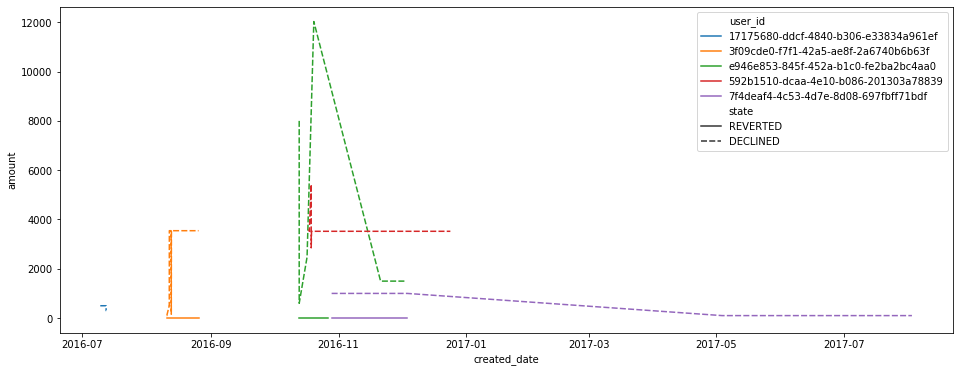

In [47]:
# transactions by designated_fr_users

designated_fr_users = [
    uuid.UUID('7f4deaf4-4c53-4d7e-8d08-697fbff71bdf'),
    uuid.UUID('3f09cde0-f7f1-42a5-ae8f-2a6740b6b63f'),
    uuid.UUID('e946e853-845f-452a-b1c0-fe2ba2bc4aa0'),
    uuid.UUID('592b1510-dcaa-4e10-b086-201303a78839'),
    uuid.UUID('17175680-ddcf-4840-b306-e33834a961ef')
]

trx_by_possible_fr_users = df_all_trx.loc[(df_all_trx['user_id'].isin(designated_fr_users))]

trx_by_possible_fr_users.head()

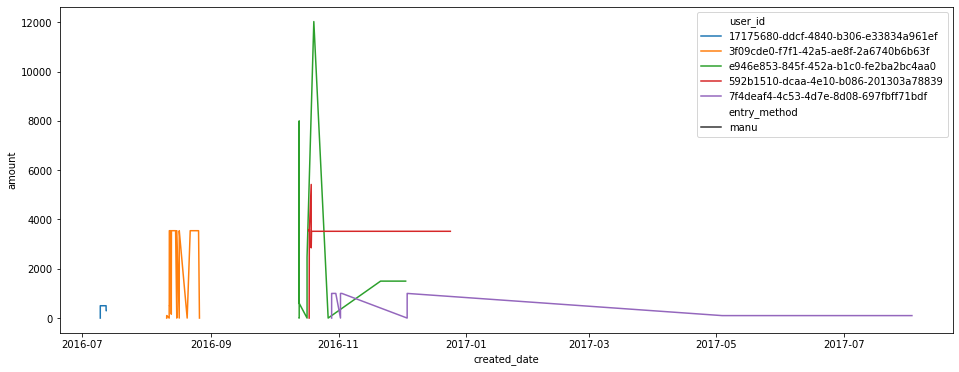

In [78]:
# line plot of trx by fraudulent users
# matplotlib.pyplot.figure(figsize=(16, 6))
# line_trx_by_fed_usr = sns.lineplot(x='created_date', y='amount', hue='user_id', style='state', data=trx_by_possible_fr_users)

# matplotlib.pyplot.figure(figsize=(16, 6))
# line_trx_by_fed_usr_type = sns.lineplot(x='created_date', y='amount', hue='user_id', style='type', data=trx_by_possible_fr_users)

matplotlib.pyplot.figure(figsize=(16, 6))
line_trx_by_fed_usr_entry_method = sns.lineplot(x='created_date', y='amount', hue='user_id', style='entry_method', data=trx_by_possible_fr_users.loc[trx_by_possible_fr_users['type'] == 'CARD_PAYMENT'])

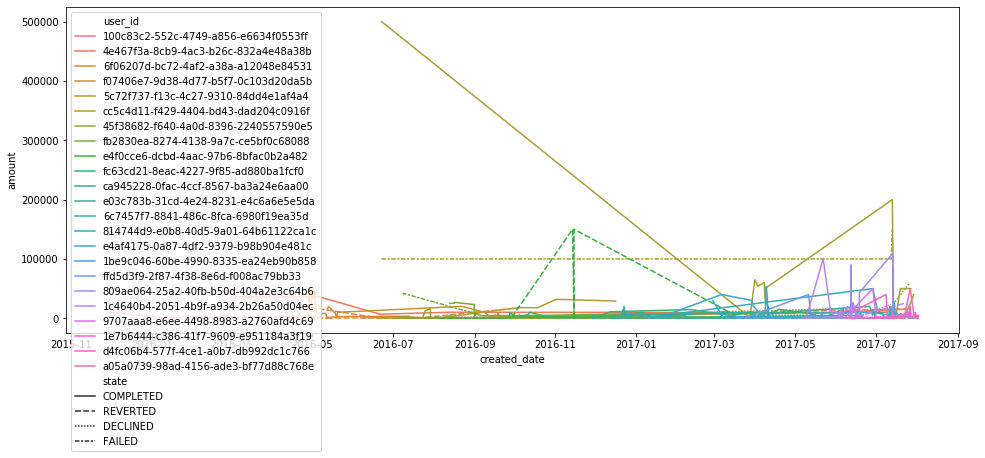

In [64]:
# transactions by median_nr_user

list_median_nr_user = median_nr_user.to_list()

trx_by_median_nr_user = df_all_trx .loc[(df_all_trx['user_id'].isin(list_median_nr_user)) & (df_all_trx['created_date'] <= '2017-08-02') & (~df_all_trx['user_id'].isin(designated_fr_users))]

trx_by_median_nr_user.head()

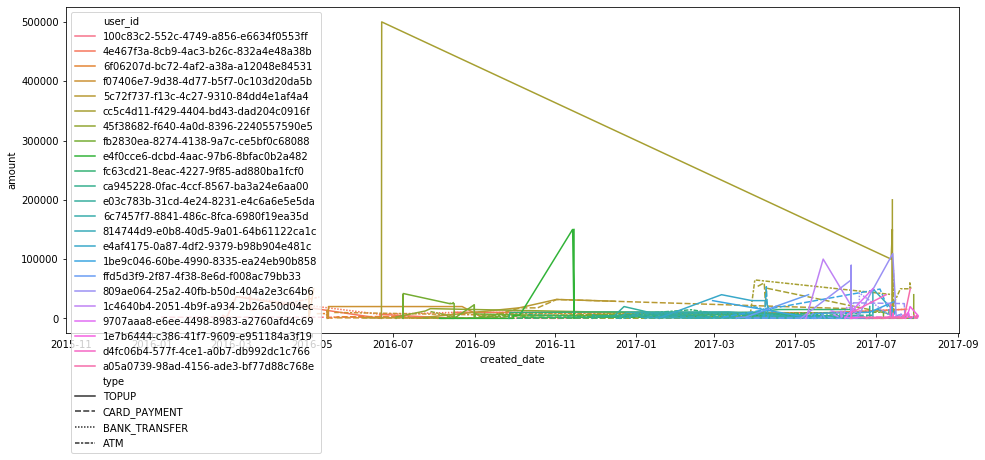

In [77]:
# median nr users line plot graph w/ hue=user_id

# matplotlib.pyplot.figure(figsize=(16, 6))
# line_trx_by_med_nr_usr = sns.lineplot(x='created_date', y='amount', hue='user_id', style='state', data=trx_by_median_nr_user)

# median nr users line plot graph w/ hue=type
matplotlib.pyplot.figure(figsize=(16, 6))
lp_nr_usr_id_type = sns.lineplot(x='created_date', y='amount', hue='user_id', style='type', data=trx_by_median_nr_user)

# median nr users line plot graph w/ hue=entry_method
# matplotlib.pyplot.figure(figsize=(16, 6))
# lp_nr_usr_id_entry_method = sns.lineplot(x='created_date', y='amount', hue='user_id', style='entry_method', data=trx_by_median_nr_user.loc[trx_by_median_nr_user['type'] == 'CARD_PAYMENT'])

In [ ]:
fig = pylab.figure()
figlegend = pylab.figure(figsize=(3,2))
ax = fig.add_subplot(111)
lines = ax.plot(range(10), pylab.randn(10), range(10), pylab.randn(10))
figlegend.legend(lines, ('one', 'two'), 'center')
fig.show()
figlegend.show()
figlegend.savefig('legend.png')